In [1]:
import serial
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

baud_rate = 115200
mask_header = b'\xfa'
mask_tail = b'\xfe\xfe'
mask_serial_number = bytes(b'\x80\x00')

In [4]:
def int_from_bytes(xbytes: bytes) -> int:
    temp = bytearray(xbytes)
    temp.reverse()
    temp = int.from_bytes(temp, byteorder="big", signed=False)
    return temp

def bitwise_and_bytes(a, b):
    result_int = int.from_bytes(a, byteorder="big") & int.from_bytes(b, byteorder="big")
    return result_int.to_bytes(max(len(a), len(b)), byteorder="big")

def open_serial_port(port_number, baud_rate):
    serial_port = serial.Serial(port_number, baud_rate)
    print(serial_port)
    return serial_port

In [5]:
ports = list(serial.tools.list_ports.comports())
ports = sorted(ports)
serial_port = None
for p in ports:
    # find serial ports
    if "Serial Port" in p[1]: # [1] returns description of a port
        serial_port = p
        break
        

In [9]:
port_number = serial_port[0]
try:
    opened_serial_port = open_serial_port(port_number, baud_rate)     
except:
    opened_serial_port = None
    opened_serial_port = open_serial_port(port_number, baud_rate) 
    print (opened_serial_port) 

buffers = []
byte = opened_serial_port.read(1) 
print (byte)   
while byte:
    buffer = []
    if byte == mask_header:
        temp_header = byte
        byte = opened_serial_port.read(1)
        
        
        if byte == mask_header:
            header = temp_header + byte
            
            buffer.append(int_from_bytes(header))
            byte = opened_serial_port.read(2)
            
            while byte:
                if byte != mask_tail:
                    temp = int_from_bytes(byte)
                    buffer.append(temp)
                    
                    if len(
                        buffer) == 2:
                        b_array = bytearray(byte)
                        b_array.reverse()
                        temp_bitwise_and = bitwise_and_bytes(b_array, mask_serial_number)
                        buffer[-1] = int_from_bytes(temp_bitwise_and)
                    
                    byte = opened_serial_port.read(2)
                
                else:
                    tail = int_from_bytes(byte)
                    buffer.append(tail)
                    buffers.append(buffer)
                    break
                    
    byte = opened_serial_port.read(1)
    if len(buffers) == 30:
        break
    #print("len(buffer):{}, byte:{}".format(len(buffers), byte))
    mat = np.array(buffer)[2:2050]
    mat = mat.reshape(64, 32)
    print("current round:{}".format(len(buffers)), end='\r')
    #plt.imshow(mat.reshape(64, 32))

Serial<id=0x224d7c17df0, open=True>(port='COM5', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)
Serial<id=0x224d7c17df0, open=True>(port='COM5', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)
b'\xfa'


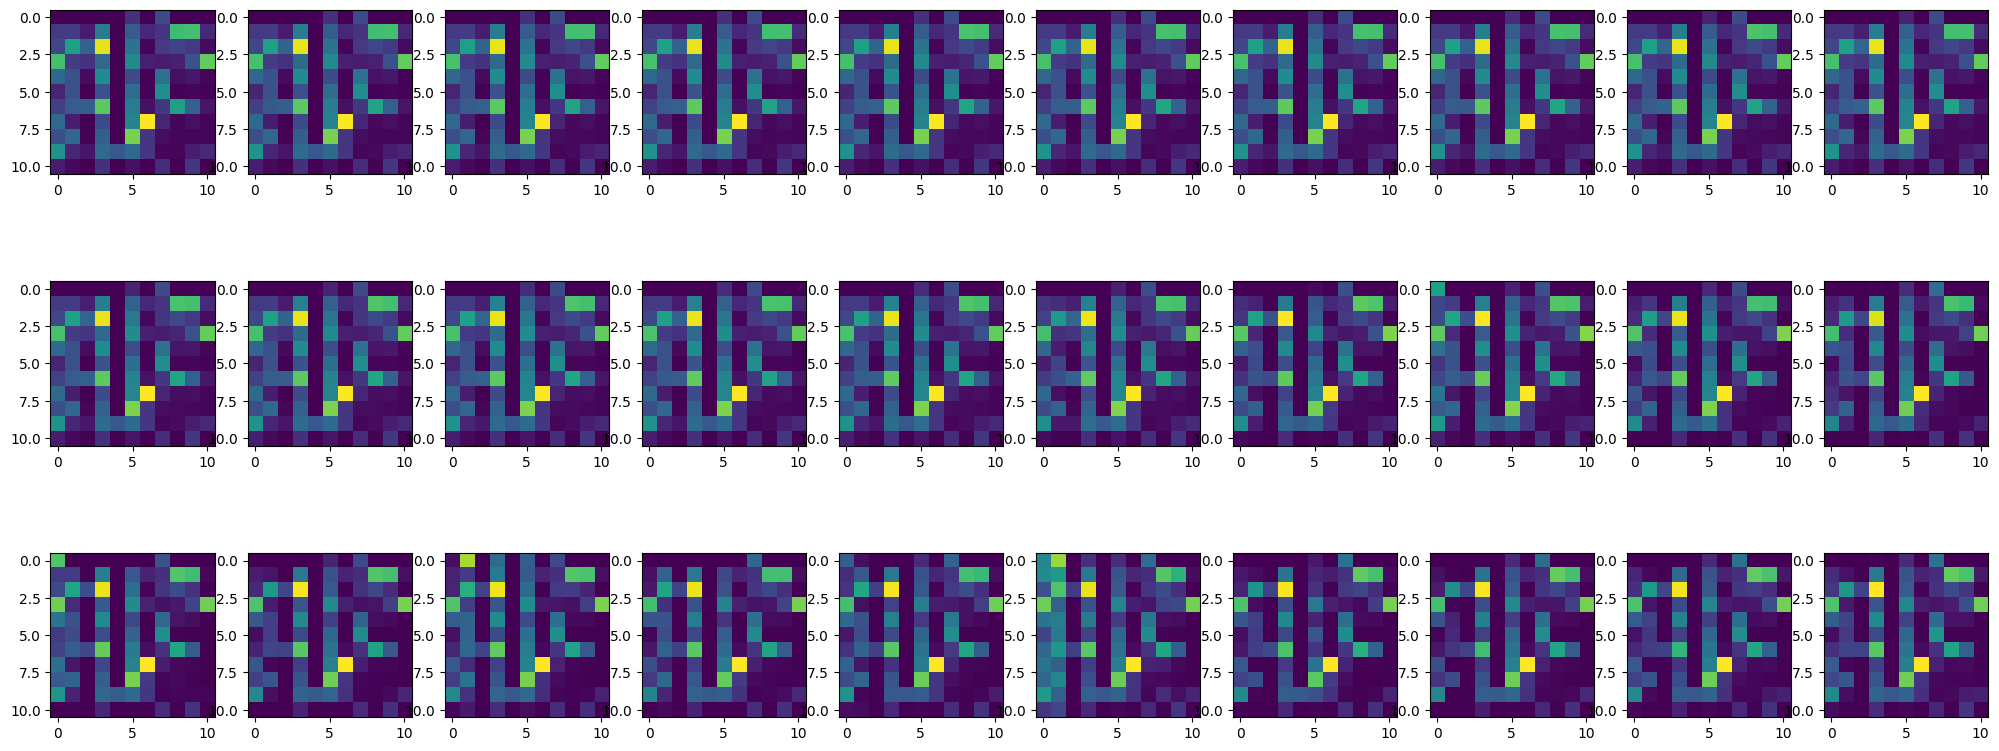

In [68]:
buffers2 = buffers
max_col = 32
max_row = 64
max_bytes = max_row * max_col
matrix = np.zeros((len(buffers2), max_row, max_col))

for i, buffer in enumerate(buffers2):
    pressure_sensor =buffer[2:2+max_bytes]
    matrix[i] = np.array(pressure_sensor).reshape(max_row, max_col)

df = pd.DataFrame(matrix.reshape(-1, 32).T)
#df = pd.DataFrame(matrix.reshape(11, 11))
df.to_csv("noise_.csv")
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11].T)
        #plt.imshow(matrix[p-1, 1:12,:11].T)
        p += 1

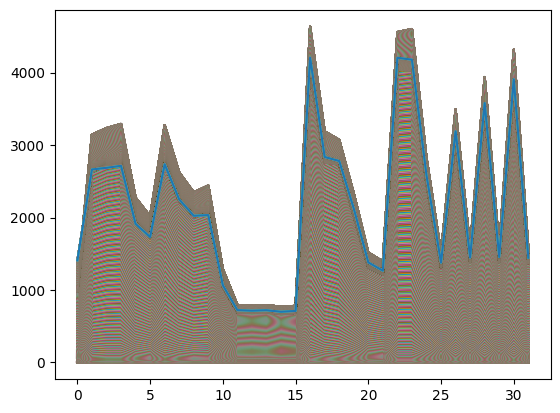

In [89]:
from scipy import signal

# Load the data into a NumPy array
data = pd.read_csv('D:\PhD Projects\Fall Risk Assesement/noise_.csv')

# Define the filter parameters
order = 4
cutoff = 0.1  # Cutoff frequency, in Hz
fs = 100  # Sample rate, in Hz

# Design the filter
b, a = signal.butter(order, cutoff / (fs / 2), 'low')

# Apply the filter to the data
filtered_data = signal.lfilter(b, a, data)
plt.plot(filtered_data)

# Add labels and a title
#plt.xlabel('Time (s)')
#plt.ylabel('Amplitude')
#plt.title('Filtered Data')

# Show the plot
plt.show()

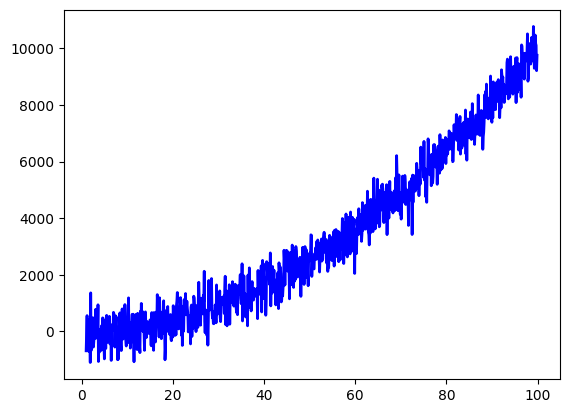

In [41]:
import matplotlib.pyplot as plt
import numpy as np

mu, sigma = 0, 500

num_fig_col = np.arange(1, 100, 0.1)  # x axis
z = np.random.normal(mu, sigma, len(num_fig_col))  # noise
num_fig_row = num_fig_col ** 2 + z  # data
plt.plot(num_fig_col, num_fig_row, linewidth=2, linestyle="-", c="b")  # it includes some noise

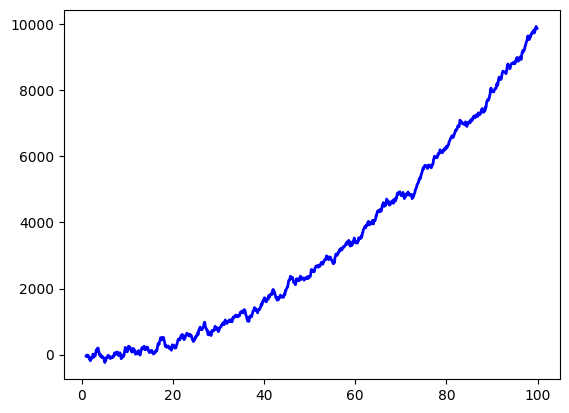

In [42]:
from scipy.signal import lfilter

n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b, a, num_fig_row)
plt.plot(num_fig_col, yy, linewidth=2, linestyle="-", c="b")  # smooth by filter


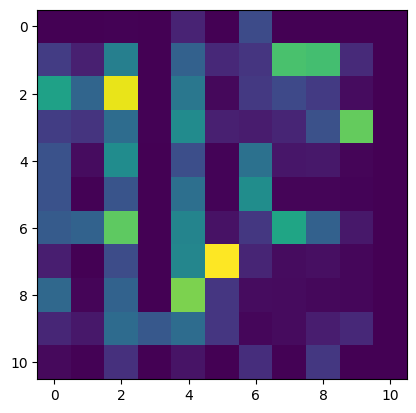

In [79]:

plt.imshow(matrix[10, 1:12,:11].T)

In [87]:
matrix[0, :11, :11]

array([[  775.,  8402., 10548., 33270., 16298.,  5422.,  9514., 16550.,
        11887., 23984.,  4335.],
       [  742.,  8704., 26957.,  8925., 12371., 12187., 13891.,  4471.,
        16083.,  5653.,  1848.],
       [  759.,  4217., 15363.,  7245.,  2019.,   894., 14608.,   803.,
         1234.,  3433.,   883.],
       [ 1059., 20338., 44976., 16584., 22887., 12405., 35236., 11057.,
        14697., 16521.,  6886.],
       [  754.,   736.,   840.,   931.,   722.,   743.,   779.,   763.,
          777., 13228.,   748.],
       [ 6908., 14203., 18234., 22511., 11324., 17229., 20316., 21553.,
        37451., 16672.,  2799.],
       [  737.,  5838.,  1587.,  4786.,  1139.,  1124.,  2763., 46804.,
         8064.,  7932.,   746.],
       [11045.,  7858.,  8296.,  4210., 17878., 23296.,  8205.,  5494.,
         2278.,  1523.,  6786.],
       [  736., 32514.,  9933.,  4741.,  2651.,  1088., 26751.,  1608.,
         1360.,  1492.,   896.],
       [  738., 33247.,  8389., 12104.,  3724.,  1280.,

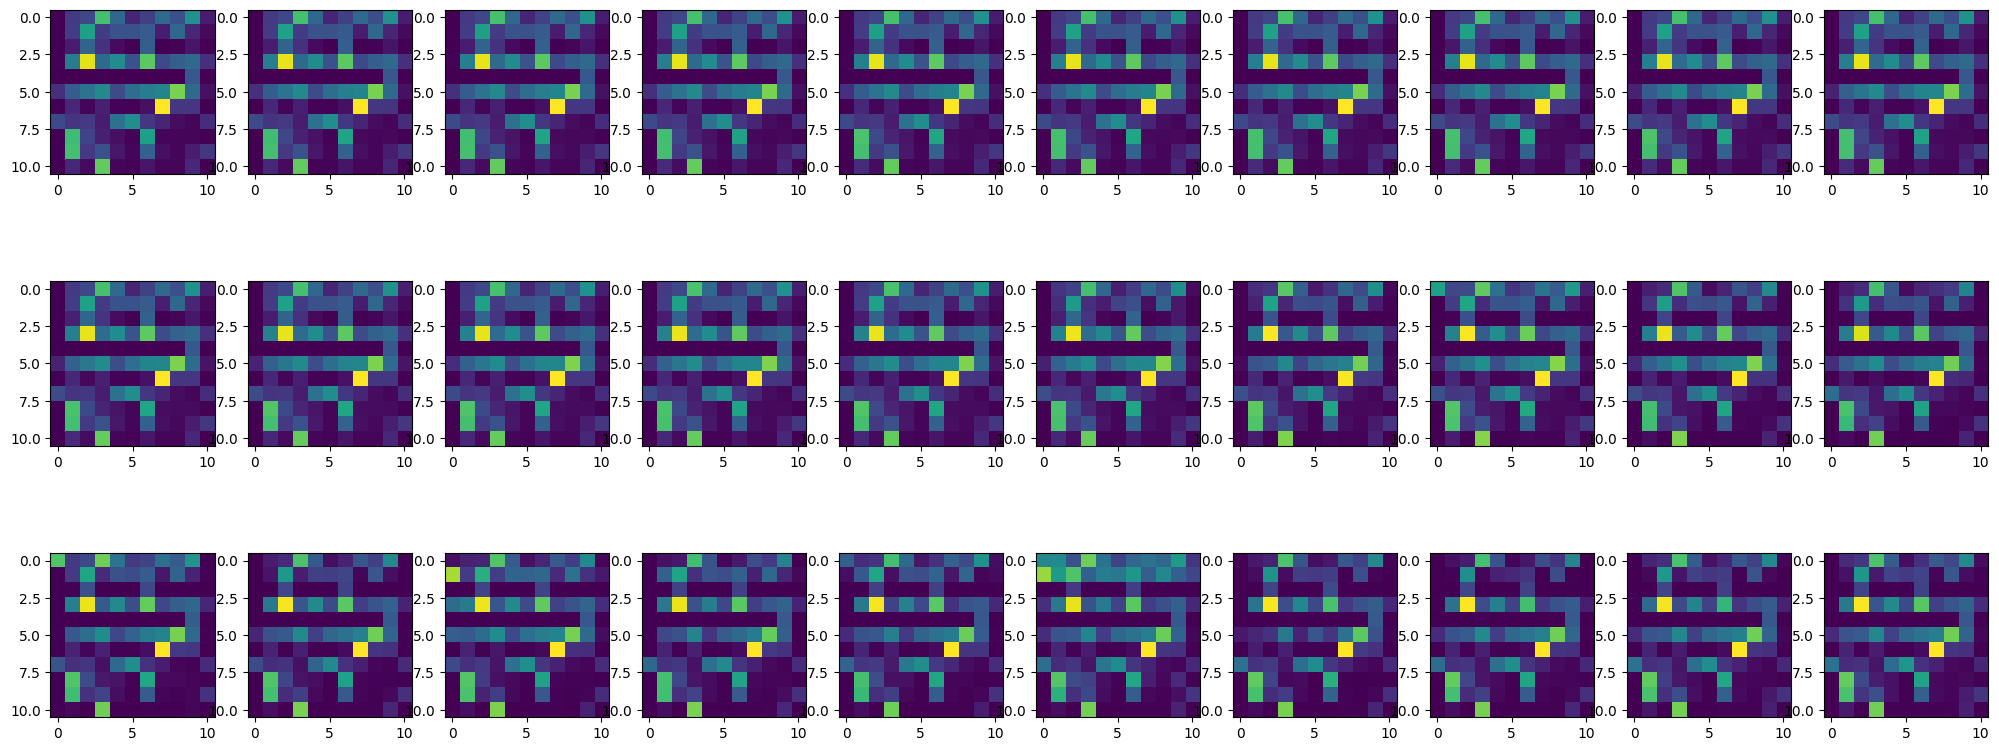

In [88]:
buffers1 = buffers
max_col = 32
max_row = 64
max_bytes = max_row * max_col
matrix = np.zeros((len(buffers1), max_row, max_col))

for i, buffer in enumerate(buffers1):
    pressure_sensor =buffer[2:2+max_bytes]
    matrix[i] = np.array(pressure_sensor).reshape(max_row, max_col)
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11])
        p += 1

In [53]:
df = pd.read_csv("balance_3.csv")

In [54]:
df = df.to_numpy()

In [55]:
df = df[:, 1:]
matrix = df.reshape(-1,64, 32)

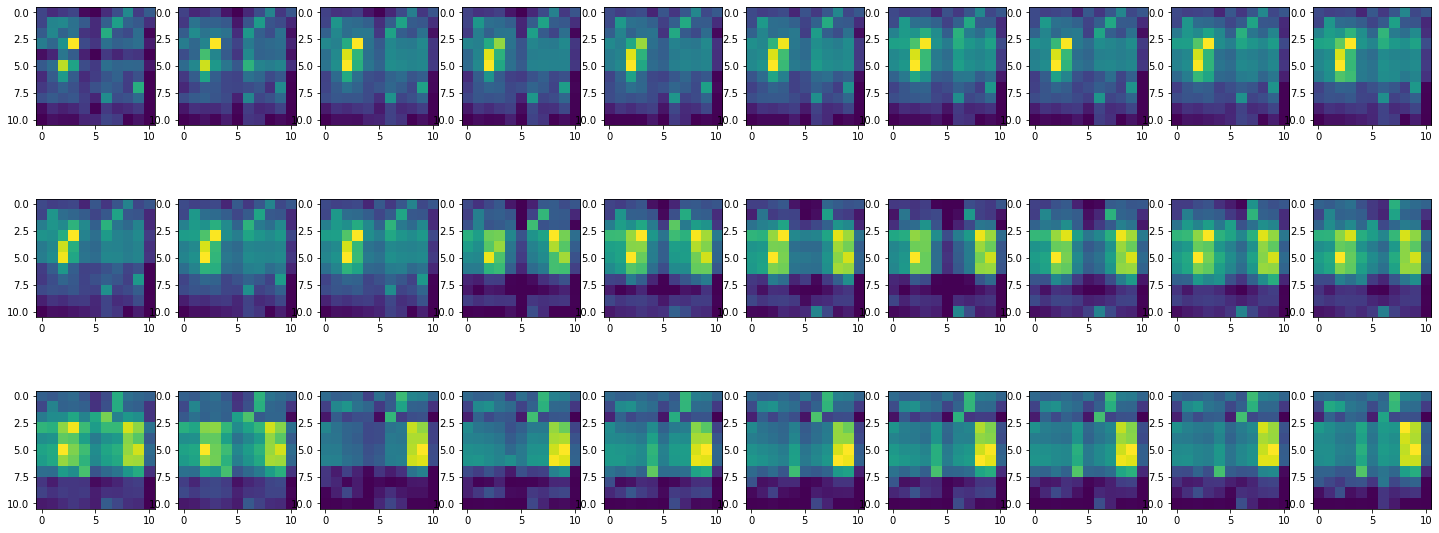

In [56]:
plt.figure(figsize=(25, 10))
num_fig_col = 10
num_fig_row = len(matrix) // num_fig_col
p = 1
for i in range(0, num_fig_row):
    for j in range(0, num_fig_col):
        plt.subplot(num_fig_row, num_fig_col, p)
        plt.imshow(matrix[p-1, :11,:11])
        p += 1